In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [2]:
# Carga el dataset con indicadores técnicos y features derivadas
df = pd.read_csv('data/BTC_5m_features.csv')

# Revisar estructura
df.head()


,timestamp,open,high,low,close,volume,log_return,pct_change,sma_20,stddev_20,...,returns_mean_20,returns_std_20,ema_diff,rsi_macd_ratio,bb_position,rsi_overbought,rsi_oversold,macd_cross,volatility,vol_ratio
0,2024-01-01 09:45:00,42639.02,42690.00,42622.29,42636.40,83.06555,-0.000061,-0.000061,42560.8750,66.808439,...,0.000178,0.000773,41.245836,1.480724,0.782618,0,0,1,0.000773,1.463030
1,2024-01-01 09:50:00,42636.40,42651.10,42620.54,42650.15,39.03884,0.000322,0.000322,42567.6685,68.702211,...,0.000160,0.000764,41.681319,1.502580,0.800141,0,0,1,0.000764,0.689938
2,2024-01-01 09:55:00,42650.16,42650.16,42621.60,42649.69,37.98421,-0.000011,-0.000011,42574.4425,69.823784,...,0.000159,0.000764,41.510814,1.506583,0.769419,0,0,1,0.000764,0.662783
3,2024-01-01 10:00:00,42649.69,42664.50,42645.69,42645.69,64.74272,-0.000094,-0.000094,42581.1850,69.869637,...,0.000158,0.000764,40.585081,1.520474,0.730805,0,0,1,0.000764,1.101647
4,2024-01-01 10:05:00,42645.70,42692.23,42645.69,42654.00,63.74115,0.000195,0.000195,42589.7850,67.566232,...,0.000202,0.000739,40.060190,1.567989,0.737600,0,0,1,0.000739,1.058243


In [3]:
# Definición de features y target
features = [
    'log_return', 'pct_change',
    'rsi', 'ema_12', 'ema_26',
    'macd', 'macd_signal', 'macd_histogram',
    'bb_upper', 'bb_lower', 'bb_width',
    'returns_mean_5', 'returns_std_5',
    'returns_mean_20', 'returns_std_20',
    'ema_diff',
    'rsi_macd_ratio',
    'bb_position',
    'rsi_overbought', 'rsi_oversold',
    'macd_cross',
    'volatility', 'adx', 'atr', 'vol_ratio'
]

# Features (X) y target (y)
X = df[features]
y = df['target']


In [4]:
# División 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Revisión de tamaños
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (101435, 25)
X_test shape: (25359, 25)


In [5]:
# Definir el modelo XGBoost
model_xgb = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

# Entrenar modelo
model_xgb.fit(X_train, y_train)

# Guardar el modelo
joblib.dump(model_xgb, 'models/xgb_btc_model.pkl')
print("✅ Modelo XGBoost guardado en 'models/xgb_btc_model.pkl'")


✅ Modelo XGBoost guardado en 'models/xgb_btc_model.pkl'


In [6]:
# Predicciones en test
y_pred_xgb = model_xgb.predict(X_test)

# Métricas
print("📊 Evaluación del modelo XGBoost:")
print(f"✅ Accuracy:  {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"✅ Precision: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"✅ Recall:    {recall_score(y_test, y_pred_xgb):.2f}")
print(f"✅ F1 Score:  {f1_score(y_test, y_pred_xgb):.2f}")

# Reporte detallado
print(classification_report(y_test, y_pred_xgb))


📊 Evaluación del modelo XGBoost:
✅ Accuracy:  0.51
✅ Precision: 0.51
✅ Recall:    0.49
✅ F1 Score:  0.50
              precision    recall  f1-score   support

           0       0.51      0.53      0.52     12680
           1       0.51      0.49      0.50     12679

    accuracy                           0.51     25359
   macro avg       0.51      0.51      0.51     25359
weighted avg       0.51      0.51      0.51     25359



In [7]:
# Vamos a usar el 'close' como ejemplo para LSTM
dataset = df[['close']].values

# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Crear secuencias para LSTM
sequence_length = 60
X_lstm, y_lstm = [], []

for i in range(sequence_length, len(scaled_data)):
    X_lstm.append(scaled_data[i-sequence_length:i, 0])
    y_lstm.append(1 if scaled_data[i, 0] > scaled_data[i-1, 0] else 0)

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Reshape para LSTM (samples, timesteps, features)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

print(f"X_lstm shape: {X_lstm.shape}")
print(f"y_lstm shape: {y_lstm.shape}")


X_lstm shape: (126734, 60, 1)
y_lstm shape: (126734,)


In [8]:
from tensorflow.keras.models import load_model
# Definición del modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1, activation='sigmoid'))

# Compilación
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Entrenamiento
history = model_lstm.fit(
    X_lstm, y_lstm,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Guardar el modelo
model_lstm.save('models/lstm_btc_model.keras')
print("✅ Modelo LSTM guardado en 'models/lstm_btc_model.keras")


Epoch 1/10


/opt/anaconda3/envs/tf2.11/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3169/3169 ━━━━━━━━━━━━━━━━━━━━ 61s 19ms/step - accuracy: 0.4985 - loss: 0.6935 - val_accuracy: 0.5022 - val_loss: 0.6931
Epoch 2/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 60s 19ms/step - accuracy: 0.5025 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.5021 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 56s 18ms/step - accuracy: 0.4996 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6933
✅ Modelo LSTM guardado en 'models/lstm_btc_model.keras


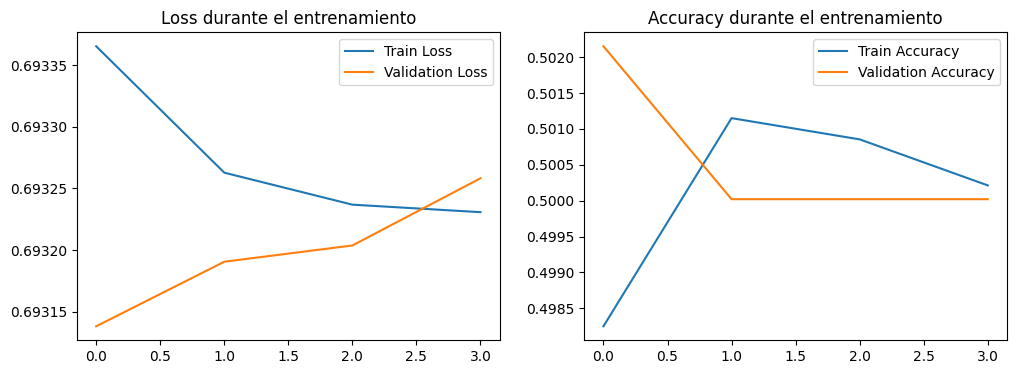

In [9]:
# Gráficos de la evolución del entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss durante el entrenamiento')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento')
plt.legend()

plt.show()
